In [1]:
## Importing necessary libraries

import numpy as np
from astropy.io import fits
from pathlib import Path
from matplotlib.colors import LogNorm
from astropy.nddata import CCDData
from itertools import cycle
from ccdproc import ImageFileCollection
import ccdproc as ccdp
import os
from astropy.stats import mad_std,sigma_clipped_stats, SigmaClip
import ccdproc as ccdp
import matplotlib.pyplot as plt
#from convenience_functions import show_image
from matplotlib.colors import LogNorm
import astropy.units as u
import glob
import photutils as pht
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from scipy.stats import median_abs_deviation as mad

In [2]:
#I created a function that gives the fits file median
def view_median_fits(fits_file):
    with fits.open(fits_file) as hdulist:
        data=hdulist[0].data
        median=np.median(data)
        print(f"Median of the FITS file: {median}")

In [3]:
#Used as a scaling function when combining flat frames (scale=inv_median in ccdp.combine).
#Ensures flats are normalized by their median brightness before stacking, preventing over/under-exposed frames from dominating the final master flat.

#Now you should create a master flat like the master dark we created before.
def inv_median(a):
    return 1 / np.median(a)
from pathlib import Path
flatpath=Path (r'C:/Users/sarin/flat')

combined_path_flat = Path(r'C:/Users/sarin/OneDrive/Desktop/combinedflat')
combined_flat_name = 'master_flat_trimonly.fits'

combined_flat_file = combined_path_flat/ combined_flat_name
if combined_flat_file.exists():
    # Read the existing combined flat file as a CCDData object
    combined_flat = CCDData.read(combined_flat_file) 
    print(f"File already exists: {combined_flat_file}")  # Print the message
else:
    # Perform the combination if the file doesn't exist
    to_combine = glob.glob(str(combined_path / 'dark_removed*'))
    # Check if any files were found
    if not to_combine:
        print("No files found to combine for combined_flat")
    else:
        # Combine the files
        combined_flat = ccdp.combine(to_combine,method='median', scale=inv_median,
                                    sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                    sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                                    mem_limit=350e6)
        combined_flat.meta['combined'] = True
        combined_flat.write(combined_path / combined_flat_name, overwrite=True)

File already exists: C:\Users\sarin\OneDrive\Desktop\combinedflat\master_flat_trimonly.fits


C:\Users\sarin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


NameError: name 'ax2' is not defined

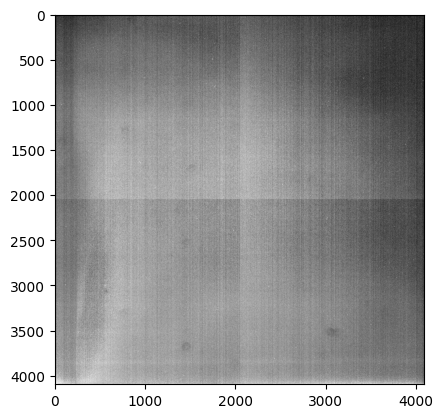

In [4]:
# Plotting:



plt.imshow(combined_flat,cmap='gray', vmin=np.percentile(combined_flat, 5), vmax=np.percentile(combined_flat, 95))
#ax2.imshow(combined_flat, vmin=50, vmax=90, origin='lower')

ax2.set_title('Combined Flats with Dark reduced_scale: inv_median',fontsize=20)
#fig.savefig("WASP12b-flat2_scale_inv_median.png")

In [29]:
#Subtracting the master dark and flat from a light Frame
path = Path(r'C:/Users/sarin')
light_frame_name='star6-2024_09_11-exp00.00.30.000-000019_High_1.fit'
combined_dark=r'C:/Users/sarin/OneDrive/Desktop/combined/master_dark_trimonly.fits'
combined_dark = CCDData.read(combined_dark, unit='adu')

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [31]:
raw_data = CCDData.read(path.joinpath(light_frame_name), unit='adu')
# Bin the raw frame by 2x2 (4096→2048)
from astropy.nddata import block_reduce
import numpy as np
binned_raw_data = block_reduce(raw_data.data, block_size=(2, 2), func=np.mean)
binned_raw = CCDData(binned_raw_data, unit=raw_data.unit, meta=raw_data.meta)
reducedark = ccdp.subtract_dark(binned_raw, combined_dark,exposure_time='EXPTIME', exposure_unit=u.second)


In [36]:
binned_flat = block_reduce(combined_flat.data, block_size=(2, 2), func=np.mean)
binned_flat = CCDData(binned_flat, unit=combined_flat.unit, meta=combined_flat.meta)
reducefd = ccdp.flat_correct(binned_raw, binned_flat)
# Check if output files already exist
combined_path =  Path(r'C:\Users\sarin\OneDrive\Desktop\combined_path')



In [39]:
# Check if output files already exist
file_name = Path(light_frame_name).name
output_files = [
    combined_path / ('light_minus_dark_only' + file_name),
    combined_path / ('light_div_falt_minus_dark' + file_name)
]


File already exists: C:\Users\sarin\OneDrive\Desktop\combined_path\light_minus_dark_onlystar6-2024_09_11-exp00.00.30.000-000019_High_1.fit
File already exists: C:\Users\sarin\OneDrive\Desktop\combined_path\light_div_falt_minus_darkstar6-2024_09_11-exp00.00.30.000-000019_High_1.fit


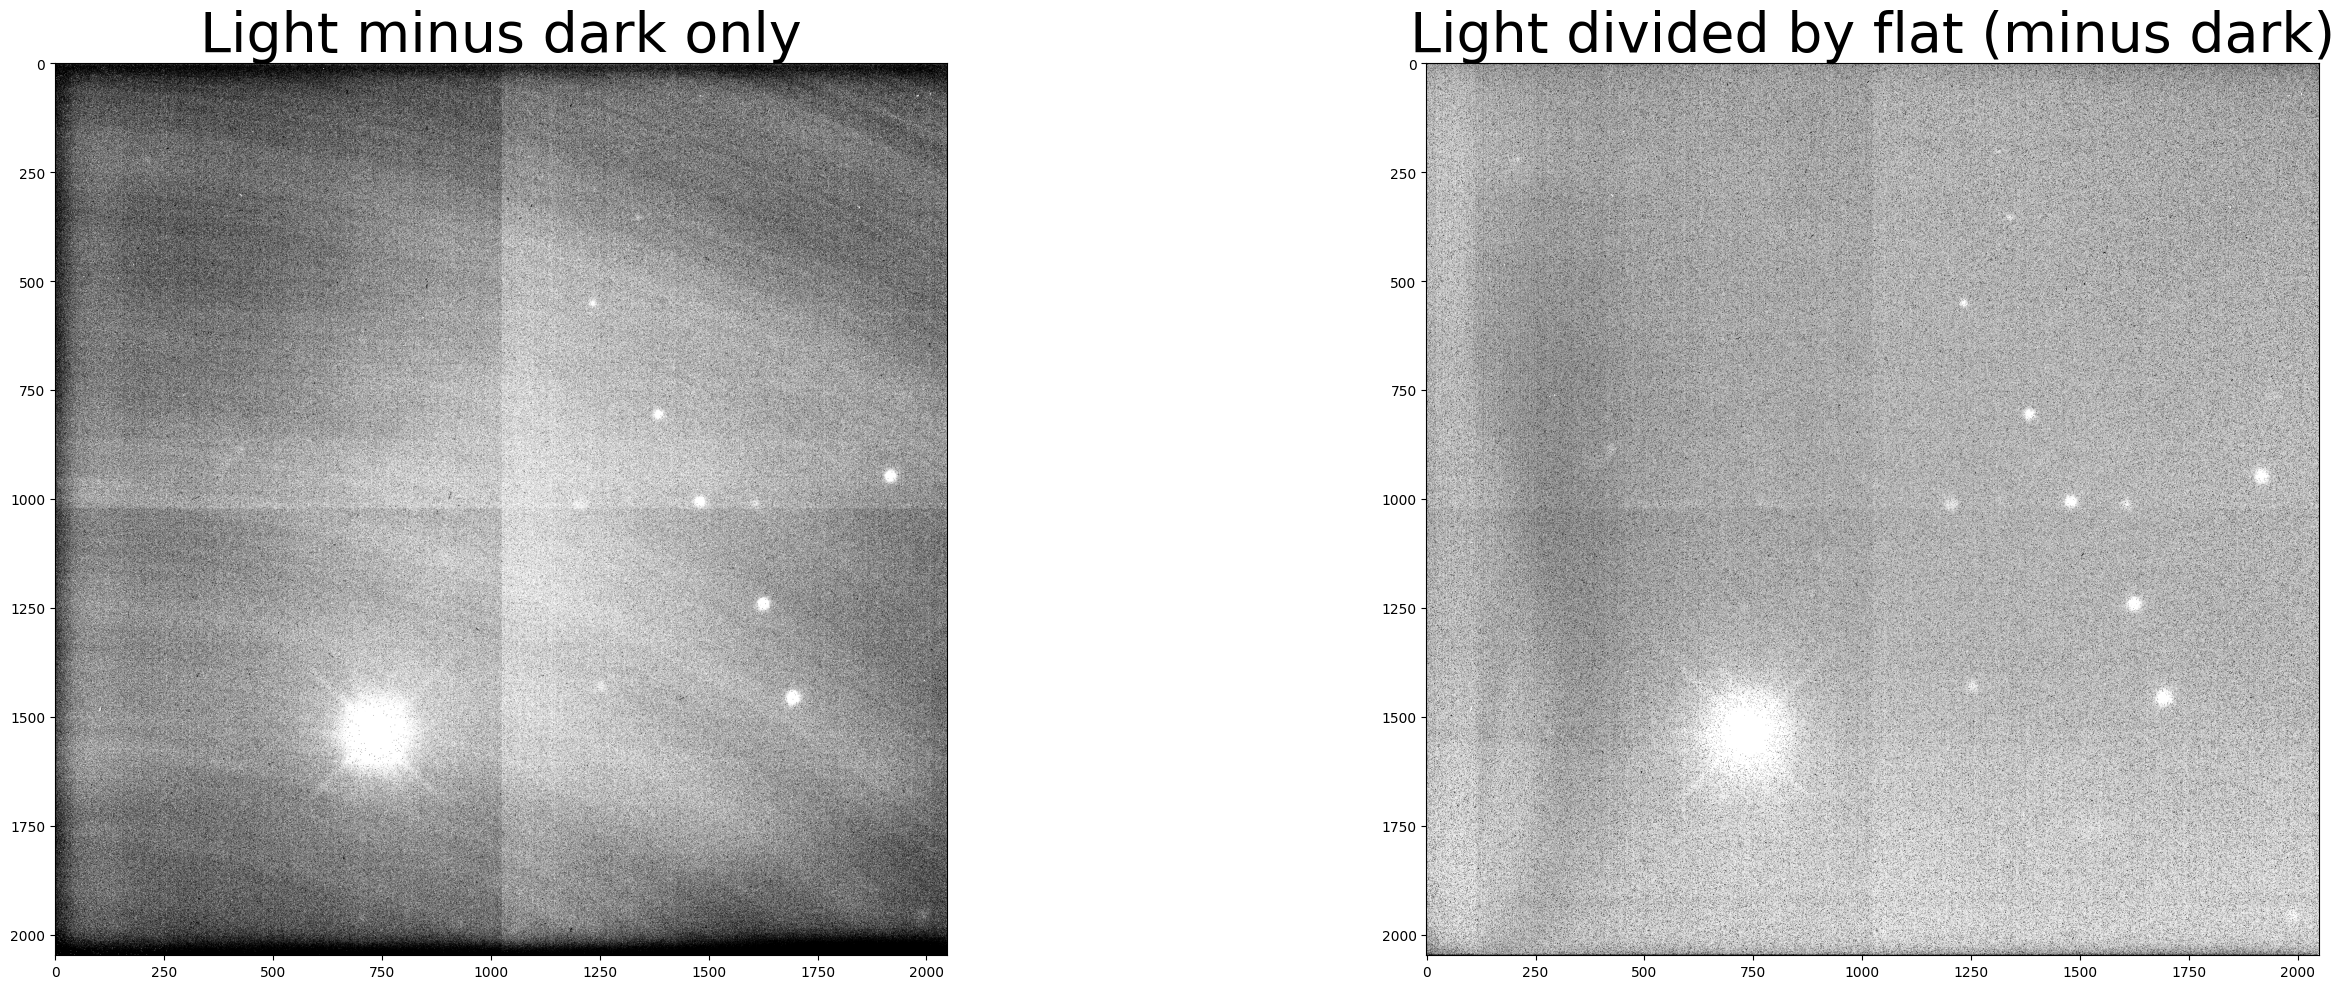

In [42]:
for output_file in output_files:
    if output_file.exists():
        print(f"File already exists: {output_file}")
    else:
        # Write the output to a file
        if output_file.name == ('light_minus_dark_only' + file_name):
            reducedark.write(output_file, overwrite=True)
        elif output_file.name == ('light_div_falt_minus_dark' + file_name):
            reducefd.write(output_file, overwrite=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

# Display images using ax.imshow() instead of plt.imshow()
ax1.imshow(reducedark, cmap='gray', vmin=np.percentile(reducedark, 5), vmax=np.percentile(reducedark, 95))
ax1.set_title('Light minus dark only', fontsize=40)

ax2.imshow(reducefd, cmap='gray', vmin=np.percentile(reducefd, 5), vmax=np.percentile(reducefd, 95))
ax2.set_title('Light divided by flat (minus dark)', fontsize=40)

plt.tight_layout()
plt.show()